In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
dtype_Acc={'Accident_Index': str,'Location_Northing_OSGR': float,'Location_Easting_OSGR': float,'Longitude':float,
           'Latitude':float,'Local_Authority_(Highway)':str,'LSOA_of_Accident_Location':str,'time'}
parse_dates = ['Date']
# Import fir few rows of three CSV files for inspection :
Acc=pd.read_csv('Stats19_Data_2005-2014/Accidents0514.csv',parse_dates=parse_dates,dtype=dtype_Acc)
Cas=pd.read_csv('Stats19_Data_2005-2014/Casualties0514.csv',dtype={'Accident_Index':str})  # all variables dtype=int
Veh=pd.read_csv('Stats19_Data_2005-2014/Vehicles0514.csv',dtype={'Accident_Index':str})

In [7]:
Acc.Time[0][:2]

'17'

In [15]:
# Pandas Apply vs Map vs ApplyMap: https://stackoverflow.com/questions/19798153/difference-between-map-applymap-and-apply-methods-in-pandas
Acc['Time'].apply(lambda x: int(str(x)[:2]))

ValueError: invalid literal for int() with base 10: 'na'

In [21]:
Acc['Hour']=Acc['Time'].apply(lambda x: str(x)[:2])

In [45]:
# Question 1, fraction of Accident in Urban
print('fraction of urban accidents: '+str(Acc.loc[Acc['Urban_or_Rural_Area']==1]['Accident_Index'].count()/Acc['Accident_Index'].count()))

fraction of urban accidents: 0.642656910868


linear trend of accidents from 2005 to 2014: -6511.72727273


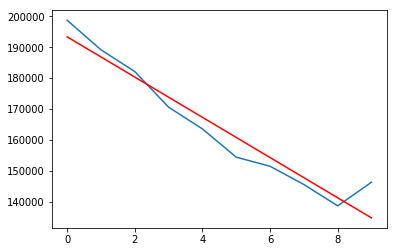

In [92]:
# Question 2 Linear trend in accident per year in Slope
#Acc.Date.loc[0].year
#Acc['Year']=Acc['Date'].apply(lambda x: x.year);
acd_year=Acc.groupby('Year')['Accident_Index'].count().values

from scipy import stats
year=np.arange(len(acd_year))
slope, intercept, r_value, p_value, std_err = stats.linregress(year,acd_year)

print('linear trend of accidents from 2005 to 2014: '+str(slope))

plt.figure()
plt.plot(acd_year)
plt.plot(year*slope+intercept,color='r')

In [122]:
# Most dangerous hour fatal/all_accidents in the highest hour
#'Number_of_Casualties'
newdf=pd.merge(Acc[['Accident_Index','Hour']],Cas[['Accident_Index','Casualty_Severity']] , on='Accident_Index')
accd_in_hour=newdf.drop_duplicates(subset='Accident_Index').groupby('Hour')['Accident_Index'].count().values
fatal_in_hour=newdf[newdf['Casualty_Severity']==1].drop_duplicates(subset='Accident_Index').groupby('Hour')['Accident_Index'].count().values
# highest percentage at 4AM
np.max(fatal_in_hour/accd_in_hour)

Correlation betwee casualty ratio and speed limit: 0.965939055511


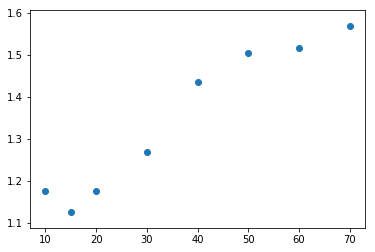

In [156]:
# Correlation between #Cas/Accd and Speedlimit >> groupby #Speed_limit
from scipy.stats import pearsonr
Acc[['Accident_Index','Number_of_Casualties','Speed_limit']] #inspect the relevant columns

cas_categories=Acc[['Accident_Index','Number_of_Casualties','Speed_limit']].groupby('Speed_limit').sum()['Number_of_Casualties'].values
accd_categories=Acc[['Accident_Index','Number_of_Casualties','Speed_limit']].groupby('Speed_limit').count()['Accident_Index'].values
speed_categories=Acc[['Accident_Index','Number_of_Casualties','Speed_limit']].groupby('Speed_limit').count()['Accident_Index'].index.values
ratio=cas_categories/accd_categories
r,p=pearsonr(ratio,speed_categories)
print('Correlation betwee casualty ratio and speed limit: '+str(r))

plt.figure()
plt.scatter(speed_categories,ratio)

In [253]:
# bad weather/ good weather
#Skidding_and_Overturning, Weather_Conditions, Accident_Index
# GoodWeather vs Precipitation
goodweather=Acc[Acc['Weather_Conditions']==1][['Accident_Index','Weather_Conditions']]
newdf_wet=Acc[Acc['Weather_Conditions'] ==2 ][['Accident_Index','Weather_Conditions']]
newdf_wet2=Acc[Acc['Weather_Conditions'] ==3 ][['Accident_Index','Weather_Conditions']]
newdf_wet3=Acc[Acc['Weather_Conditions'] ==5 ][['Accident_Index','Weather_Conditions']]
newdf_wet4=Acc[Acc['Weather_Conditions'] ==6 ][['Accident_Index','Weather_Conditions']]
result=newdf_wet.append(newdf_wet2,ignore_index=True)
result2=result.append(newdf_wet3,ignore_index=True)
wetsurface=result2.append(newdf_wet4,ignore_index=True)

# Find the kind of vehicle move:
subVeh=Veh[Veh['Skidding_and_Overturning']>0][['Accident_Index','Skidding_and_Overturning']].drop_duplicates(subset='Accident_Index')

df1=pd.merge(goodweather,subVeh, on='Accident_Index')
df2=pd.merge(wetsurface,subVeh, on='Accident_Index')

r1=len(df1)/len(goodweather)
r2=len(df2)/len(wetsurface)
print(r1)
print(r2)
print(r2/r1)

0.197027180824858
0.3441703167623293
1.7468164307150604


In [429]:
#More Fetal Accidents have Male driver''s involved

male_driver=Veh[(Veh['Sex_of_Driver']==1)&(Veh['Vehicle_Manoeuvre']!=2)][['Accident_Index','Sex_of_Driver']].drop_duplicates(subset='Accident_Index')
female_driver=Veh[(Veh['Sex_of_Driver']==2)&(Veh['Vehicle_Manoeuvre']!=2)][['Accident_Index','Sex_of_Driver']].drop_duplicates(subset='Accident_Index')

newdf_male_cas=pd.merge(male_driver, Cas[['Accident_Index','Casualty_Severity']], on='Accident_Index', how='inner')#.drop_duplicates(subset='Accident_Index')
newdf_female_cas=pd.merge(female_driver, Cas[['Accident_Index','Casualty_Severity']], on='Accident_Index', how='inner')#.drop_duplicates(subset='Accident_Index')

Total_m=newdf_male_cas.drop_duplicates(subset='Accident_Index')
Total_f=newdf_female_cas.drop_duplicates(subset='Accident_Index')

Fetal_m=newdf_male_cas[newdf_male_cas['Casualty_Severity']==1].drop_duplicates(subset='Accident_Index')
Fetal_f=newdf_female_cas[newdf_female_cas['Casualty_Severity']==1].drop_duplicates(subset='Accident_Index')

r_m=len(Fetal_m)/len(Total_m)
r_f=len(Fetal_f)/len(Total_f)
ratio=r_m/r_f
print("Fatal incidents with driver's sex considered ratio M/F: " +str(ratio))

In [435]:
# Area of police district
# sem-axis of the elipse is 1std of lon and lat for the same district
# area of elipse = np.pi*a*b in squar-kilometer (convert lat lon to km first)
# "Police_Force" is the district, groupby
# 

Lat_district=Acc[['Accident_Index','Latitude','Longitude','Police_Force']].groupby('Police_Force')[['Latitude','Longitude']].std().Latitude
Lon_district=Acc[['Accident_Index','Latitude','Longitude','Police_Force']].groupby('Police_Force')[['Latitude','Longitude']].std().Longitude#.values

Re=6371 #Earth radius in km
LatKM=Re*np.radians(Lat_district)
LonKM=Re*np.cos(np.radians(51))*np.radians(Lon_district)

Area_district=LatKM*LonKM*np.pi
print(np.max(Area_district))

22822.386423


In [348]:
## Find the exponential decay rate of accidents and driver's age (over 17)
from scipy.optimize import curve_fit
Driver_age=Veh[['Accident_Index','Age_of_Driver']]
Adult_driver=Driver_age[Driver_age['Age_of_Driver']>17]
histo_driver,edge=np.histogram(Adult_driver['Age_of_Driver'],bins=10)


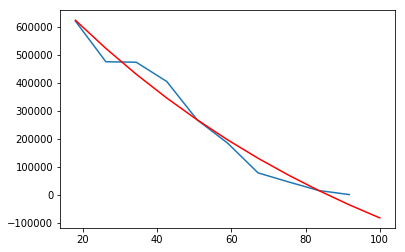

In [387]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
popt, pcov = curve_fit(func, edge[0:len(histo_driver)], histo_driver,p0=(600000, 0.01,-600000))
plt.figure()
plt.plot(edge[0:len(histo_driver)],histo_driver)
plt.plot(edge, func(edge, *popt), 'r-', label='fit')

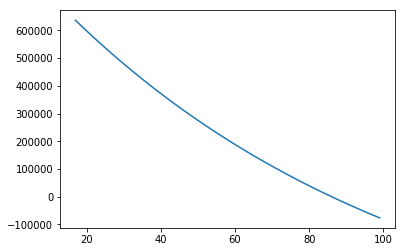

In [384]:
x=np.arange(17,100)
y=func(x,popt[0],popt[1],popt[2])
plt.plot(x,y)

In [389]:
popt

array([  1.48365810e+06,   1.03991637e-02,  -6.06574604e+05])

In [390]:
popt[1]

0.01039916367954451

In [344]:
histo_driver
curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y)

array([620872, 475589, 473810, 405142, 268222, 185024,  78769,  46434,
        15675,   1198])

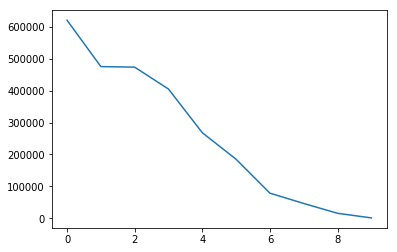

In [345]:
plt.plot(histo_driver)


In [95]:
Acc['Accident_Index'][Acc['Hour']==nan]

Series([], Name: Accident_Index, dtype: object)

In [84]:
Acc[Acc.Year==2006][['Accident_Index','Year']].count()

Accident_Index    189161
Year              189161
dtype: int64

In [33]:
Acc.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
count,1.640486e+06,1.640486e+06,1.640486e+06,1.640486e+06,1.640597e+06,1.640597e+06,1.640597e+06,1.640597e+06,1.640597e+06,1.640597e+06,...,1.640597e+06,1.640597e+06,1.640597e+06,1.640597e+06,1.640597e+06,1.640597e+06,1.640597e+06,1.640597e+06,1.640597e+06,1.640597e+06
mean,4.396051e+05,2.992476e+05,-1.436955e+00,5.258114e+01,3.082617e+01,2.838592e+00,1.831300e+00,1.351167e+00,4.117038e+00,3.540821e+02,...,3.795958e+02,9.437418e-03,7.288530e-01,1.950406e+00,1.581204e+00,1.363473e+00,1.099368e-01,7.308498e-02,1.357430e+00,1.193024e+00
std,9.550360e+04,1.614937e+05,1.404020e+00,1.454157e+00,2.554203e+01,4.017734e-01,7.152789e-01,8.260983e-01,1.924815e+00,2.593715e+02,...,1.300225e+03,1.280032e-01,1.808608e+00,1.648006e+00,1.652381e+00,6.296258e-01,7.331669e-01,6.229790e-01,4.794250e-01,4.007670e-01
min,6.495000e+04,1.029000e+04,-7.516225e+00,4.991294e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,-1.000000e+00
25%,3.754842e+05,1.781200e+05,-2.367761e+00,5.148886e+01,7.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.220000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
50%,4.403800e+05,2.666200e+05,-1.398668e+00,5.229034e+01,3.100000e+01,3.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,3.280000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
75%,5.230200e+05,3.969900e+05,-2.216495e-01,5.346786e+01,4.600000e+01,3.000000e+00,2.000000e+00,1.000000e+00,6.000000e+00,5.320000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00
max,6.555400e+05,1.208800e+06,1.762010e+00,6.075754e+01,9.800000e+01,3.000000e+00,6.700000e+01,9.300000e+01,7.000000e+00,9.410000e+02,...,9.999000e+03,2.000000e+00,8.000000e+00,7.000000e+00,9.000000e+00,5.000000e+00,7.000000e+00,7.000000e+00,3.000000e+00,3.000000e+00


In [24]:
#import dask.dataframe as dd
#ACC_df = dd.read_csv('Stats19_Data_2005-2014/Accidents0514.csv',dtype={'Location_Easting_OSGR': float,'Location_Northing_OSGR': float})